# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

downgraded or upgraded within the duration of log file

In [99]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from time import time, strftime, localtime
from pyspark.sql.types import IntegerType,DoubleType
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, isnan, explode, lit, count, when, sort_array, asc, avg, min, max, split, udf, isnull, countDistinct
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import Row
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
%matplotlib inline

In [24]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [25]:
df = spark.read.json('mini_sparkify_event_data.json')

In [26]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [27]:
# Users with NaNs in userIds or sessionIds are invalid users
# Drop invalid users
users = df.dropna(how = 'any', subset = ["userId", "sessionId"])
print('There are', users.count(), 'valid users')

There are 286500 valid users


In [28]:
# Check for duplicate users 
# Results show there are none bc valid_users counts are the same
users.select("userId").dropDuplicates().show()
users.count()

+------+
|userId|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
|     7|
|    54|
|    15|
|   155|
|   132|
|   154|
|100014|
|   101|
|    11|
|   138|
|300017|
|    29|
|    69|
|100021|
|    42|
+------+
only showing top 20 rows



286500

In [29]:
# Filter out empty userIds
valid_users = users.filter(users['userId'] != "")
print('After cleaning the data, there are', valid_users.count(), 'valid user entries.')

After cleaning the data, there are 278154 valid user entries.


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [30]:
# Explore values in page feature
valid_users.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [31]:
# Show how many cancelled which gives direct count of churn population
# Get Churn Ids
churn_users = valid_users.filter(valid_users["page"] == "Cancellation Confirmation")\
    .select("userId").dropDuplicates()

print("There are", churn_users.count(), "out of", valid_users.select("userId").dropDuplicates().count(), "users that cancelled")

There are 52 out of 225 users that cancelled


#### Note:
People that cancelled represent less than 25% of the population. Data imbalance is something to keep in mind when choosing the ML model and metrics.

### Analysis of churn by Gender

In [32]:
# Get list of churn population
churn_users_ls = [user["userId"] for user in churn_users.collect()]

# Create churn column
valid_users = valid_users.withColumn("churn", valid_users.userId.isin(churn_users_ls))

# Show table of churn counts based on gender
gender_compare = valid_users.dropDuplicates(['userId'])\
    .groupby(['gender','churn']).count().sort("gender")

gender_compare.show()

# Get churn rates based on Gender
total_F_users = valid_users.select("userId", "churn")\
    .where(valid_users.gender == "F").dropDuplicates().count()

churn_F = valid_users.select("userId")\
    .where((valid_users.churn == 1) & (valid_users.gender =='F'))\
    .dropDuplicates().count()

total_M_users = valid_users.select("userId", "churn").where(valid_users.gender == "M")\
    .dropDuplicates().count()

churn_M = valid_users.select("userId")\
                            .where((valid_users.churn == 1) & (valid_users.gender =='M')).dropDuplicates().count()

churn_rate_F = churn_F / total_F_users
churn_rate_M = churn_M / total_M_users

print("Churn rate of female users: %.2f"%churn_rate_F)
print("Churn rate of male users: %.2f"%churn_rate_M)

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F| true|   20|
|     F|false|   84|
|     M| true|   32|
|     M|false|   89|
+------+-----+-----+

Churn rate of female users: 0.19
Churn rate of male users: 0.26


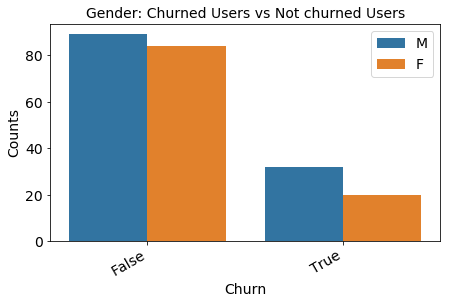

In [100]:
# Visualization
gender_df = gender_compare.toPandas()


fig = plt.figure(figsize=(7, 4));
sns.barplot(x='churn', y='count', hue='gender', 
            hue_order=['M', 'F'], data=gender_df );
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title("Gender: Churned Users vs Not churned Users", fontsize=14 )
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.legend(loc='best', fontsize=14);

#### Results
It is shown that there is a difference in churn rates between genders where males have a higher churn rate. This can be verfied with full sized data instead of mini or medium sized one.

## Analysis of churn by Level

In [101]:
#Adding Churn 'label' column to indicate user when downgrading 
users_churned=df.filter(df.page == 'Cancellation Confirmation').select('userId').dropDuplicates().toPandas()
get_churn=udf(lambda x : 'True' if x in users_churned.userId.values else 'False')
df=df.withColumn('label',get_churn(df.userId))
df.collect()
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, label: string]

In [102]:
def set_labels(ax,xlabel,ylabel,title=None):
    
    ''' Add labels to  the figure in the charts
    axis       - string: "x" or "y"
    xlabel      - string
    ylabel - string
    title - string
    '''
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title is not None :
        ax.set_title(title)


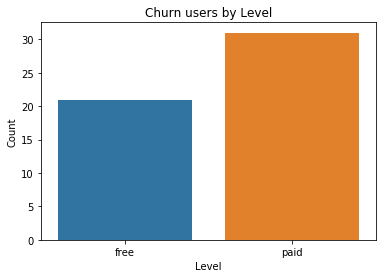

In [103]:
#churn by their Level 
churn_level = df.filter("page=='Cancellation Confirmation'").select(['level',col('label') \
                .alias('churn')]).groupby('level').count().toPandas()

ax=sns.barplot(x='level',y='count',data=churn_level)
set_labels(ax,'Level','Count','Churn users by Level');

### Results

The above visualisation clearly shows  that churn is more for paid users then free users which seems to be the logical reason as they might not be happy with the offers or services which come with paid subscription. The thing to note is free users churn is quite high as well, sparkify has to really pull up their socks and provide the offer


### What can be said based on the active pages by users distribution and relative differences between active and churned users?

In [104]:
churned= valid_users.filter(valid_users.churn==1)
active = valid_users.filter(valid_users.churn==0)

n_churned = churned.count()
n_active  = active.count()


churned_df= churned.filter(churned.page!="NextSong").groupby(["page"]).count()
churned_df= churned_df.withColumn("Churned", churned_df["count"]/(n_churned)).sort("page")

active_df = active.filter(active.page!="NextSong").groupby(["page"]).count()
active_df = active_df.withColumn("Active", active_df["count"]/(n_active)).sort("page")

churned_active_df = churned_df.join(active_df, "page", "outer").drop("count")\
    .fillna(0).toPandas()

churned_active_df.head()

,page,Churned,Active
0,Cancel,0.001159,0.000000
1,Submit Downgrade,0.000201,0.000231
2,Thumbs Down,0.011056,0.008787
3,Home,0.037268,0.036050
4,Downgrade,0.007512,0.007364


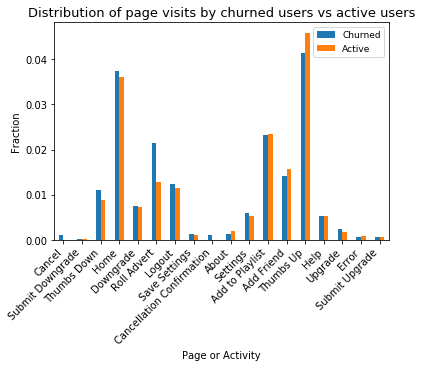

In [105]:
# Visualization
churned_active_df.plot.bar("page");
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Page or Activity", fontsize=10)
plt.ylabel("Fraction", fontsize=10)
plt.title("Distribution of page visits by churned users vs active users", fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(loc='best', fontsize=9);

### Results


As show by the figure above, there are differences in pages (and activities) between churned and active users. The higher fraction of the thumbs down page from the churned users suggest they did not like the content (music). The slightly higher downgrade fraction from the churned users suggest that there are signs, before a user churns; the churned population also has the higher upgrade fraction compared to the active users. The highest difference comes from roll advertisements which is understandable why it would lead users to cancel and log out. A higher fraction of the churned users using settings more often suggests that they are having trouble customizing their experience, leading them to churn. Active users tend to be more interactive as they add friends more often and click thumbs up on the content.  


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:

# Time span since registration
feature_time = valid_users \
    .select('userId','registration','ts') \
    .withColumn('lifetime',(df.ts-valid_users.registration)) \
    .groupBy('userId') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
feature_time.describe().show()

In [ ]:
# users listen the total songs
feature_songs = valid_users \
    .select('userID','song') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_songs')
feature_songs.describe().show()


In [ ]:
# Number of Thumbs-Up
feature_thumbsup = valid_users \
    .select('userID','page') \
    .where(valid_users.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_up') 
feature_thumbsup.describe().show()


In [ ]:
# Number of Thumbs-down
feature_thumbsdown = valid_users \
    .select('userID','page') \
    .where(valid_users.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_down')
feature_thumbsdown.describe().show()

In [ ]:
# Number of songs added to playlist
feature_addplist = valid_users \
    .select('userID','page') \
    .where(valid_users.page == 'Add to Playlist') \
    .groupBy('userID')\
    .count() \
    .withColumnRenamed('count', 'add_to_playlist')
feature_addplist.describe().show()

In [ ]:
# Number of friends added
feature_addfriend= valid_users \
    .select('userID','page') \
    .where(valid_users.page == 'Add Friend') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'add_friend') 
feature_addfriend.describe().show()


In [ ]:
# Total length of listening
feature_listenlen = valid_users \
    .select('userID','length') \
    .groupBy('userID') \
    .sum() \
    .withColumnRenamed('sum(length)', 'listen_time')
feature_listenlen.describe().show()

In [ ]:
# Number of songs listened per session
feat_lensession = valid_users.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'avg_songs_played')
feat_lensession.describe().show()

In [ ]:
#gender Encoding
feature_genderEnc = valid_users \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))
feature_genderEnc.describe().show()

In [ ]:
# Number of artists Played
feature_ArtistPl = valid_users \
    .filter(valid_users.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "artist_count")
feature_ArtistPl.describe().show()

In [42]:
# Churn label

label = valid_users \
.select('userId', col('churn').cast('int')) \
.dropDuplicates() \
.withColumnRenamed('churn', 'label')
label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996326|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [43]:
#joining all the feature engineered 
data = feature_time.join(feature_songs,'userID','outer') \
    .join(feature_thumbsup,'userID','outer') \
    .join(feature_thumbsdown,'userID','outer') \
    .join(feature_addplist,'userID','outer') \
    .join(feature_addfriend,'userID','outer') \
    .join(feature_listenlen,'userID','outer') \
    .join(feat_lensession,'userID','outer') \
    .join(feature_genderEnc,'userID','outer') \
    .join(feature_ArtistPl,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

data.show(5)

+------------------+-----------+------------+--------------+---------------+----------+------------------+------------------+------+------------+-----+
|          lifetime|total_songs|num_thumb_up|num_thumb_down|add_to_playlist|add_friend|       listen_time|  avg_songs_played|gender|artist_count|label|
+------------------+-----------+------------+--------------+---------------+----------+------------------+------------------+------+------------+-----+
|  55.6436574074074|        381|          17|             5|              7|         4| 66940.89735000003|39.285714285714285|     1|         252|    0|
| 70.07462962962963|        474|          21|             6|              8|         4| 94008.87593999993|              64.5|     0|         339|    0|
| 71.31688657407408|         11|           0|             0|              0|         0|2089.1131000000005|               8.0|     0|           8|    1|
|131.55591435185184|       4825|         171|            41|            118|        74|1

In [44]:
data.printSchema()

root
 |-- lifetime: double (nullable = false)
 |-- total_songs: long (nullable = true)
 |-- num_thumb_up: long (nullable = true)
 |-- num_thumb_down: long (nullable = true)
 |-- add_to_playlist: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- listen_time: double (nullable = false)
 |-- avg_songs_played: double (nullable = false)
 |-- gender: integer (nullable = true)
 |-- artist_count: long (nullable = true)
 |-- label: integer (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

To standardise the data value for each column to remove the bias in the dataset, we will scale our feature with StandardScaler function


In [48]:
cols = ["lifetime","total_songs","num_thumb_up",'num_thumb_down','add_to_playlist',
        'add_friend','listen_time','avg_songs_played','gender','artist_count']

assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(data)

# standard scaler
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

IllegalArgumentException: 'Output column NumFeatures already exists.'

In [50]:
# assemble and scale features for ML modeling
data.head()

Row(lifetime=55.6436574074074, total_songs=381, num_thumb_up=17, num_thumb_down=5, add_to_playlist=7, add_friend=4, listen_time=66940.89735000003, avg_songs_played=39.285714285714285, gender=1, artist_count=252, label=0, NumFeatures=DenseVector([55.6437, 381.0, 17.0, 5.0, 7.0, 4.0, 66940.8974, 39.2857, 1.0, 252.0]), features=DenseVector([1.4775, 0.2866, 0.2596, 0.3823, 0.214, 0.1943, 0.2431, 0.9219, 2.0013, 0.4173]))

### Train, test split

In [51]:
# train, validation, test split


train, rest = data.randomSplit([0.7, 0.3], seed=42)
validation, test = rest.randomSplit([0.6, 0.4], seed=42)

Now that we have the data ready for training/Test. We will now setup a base model on which our trained models will be compared.

Base Model

Since we have a imbalance data set with less churn users,we will create two base models for both churners as well as non churners. After that we will check the F1 score for the base model and compare it with the trained models

In [392]:
results_base_all_1 = test.withColumn('prediction', lit(1.0))
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_base_all_1, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(results_base_all_1, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.25
F1 Score:0.10000000000000002


In [393]:
results_base_all_0 = test.withColumn('prediction', lit(0.0))
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_base_all_0, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(results_base_all_0, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.75
F1 Score:0.6428571428571428


In [52]:
# initialize Logistic Regression classifier
lr = LogisticRegression(seed=42)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter,[5, 10]) \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics

results_lr = cvModel_lr.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression Metrics:
Accuracy: 0.8571428571428571
F-1 Score:0.7912087912087912


In [69]:
print("The best performing maxIter parameter is: ", cvModel_lr.bestModel._java_obj.getMaxIter())

The best performing regularization parameter is:  10


In [53]:
# initialize GBT classifier
GradBoostTree = GBTClassifier(seed=42)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(GradBoostTree.maxIter,[5, 10]) \
    .build()

crossval_GradBoostTree = CrossValidator(estimator=GradBoostTree,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

cvModel_GradBoostTree = crossval_GradBoostTree.fit(train)
cvModel_GradBoostTree.avgMetrics

results_GradBoostTree = cvModel_GradBoostTree.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_GradBoostTree, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(results_GradBoostTree, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Metrics:
Accuracy: 0.7857142857142857
F1 Score:0.7542857142857142


In [70]:
print("The best performing maxIter parameter is: ", cvModel_GradBoostTree.bestModel._java_obj.getMaxIter())

The best performing maxIter parameter is:  5


In [71]:
# initialize Randomforest classifier
rfor = RandomForestClassifier()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(rfor.numTrees,[5, 10]) \
    .build()


cv_rf= CrossValidator(estimator=rfor,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

cvModel_rf = cv_rf.fit(train)
cvModel_rf .avgMetrics

results_cvModel_rf  = cvModel_rf .transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('random Forest Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_cvModel_rf, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(results_cvModel_rf, {evaluator.metricName: "f1"})))

random Forest Metrics:
Accuracy: 0.8571428571428571
F1 Score:0.7912087912087912


In [77]:
print("The best performing max numTree parameter is: ", cvModel_rf.bestModel._java_obj.getNumTrees())

The best performing max numTree parameter is:  5


#### Base model  Outcome:


Logistric Regression and Random forest worked well than the Gradient Boosted Tree. Hence, we will with Logistic Regression  with parameter tuning and using it as our model for further steps.

For performance metrics we will look for 'F1 score' as its a parameter to understand the change in relationship between precision and recall. We should be focusing on higher precision since we want to make sure that the customer who tend to be churned should be detected early and give them some promotion offer to keep them, else the organization would lose valuable customers

### Hyperparameter Tuning


In [75]:


f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
lr = LogisticRegression()
paramGrid = ParamGridBuilder().addGrid(lr.maxIter, [5,8,10])\
                                .addGrid(lr.regParam, [0,0.1]) \
                                .addGrid(lr.elasticNetParam, [0.001,0.01,0.05]) \
                                .build()
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, \
                        evaluator=f1_evaluator, numFolds=3)

In [76]:

lrModel = lr_cv.fit(train)
bestModel = lrModel.bestModel

In [97]:
print ("The best parameter truned out for - maxIter is:",bestModel._java_obj.getMaxIter(),"RegParam is:",bestModel._java_obj.getRegParam(), "ElasticNetPram is:",bestModel._java_obj.getElasticNetParam()) 

The best parameter truned out for - maxIter is: 10 RegParam is: 0.0 ElasticNetPram is: 0.001


### Results

In [400]:
results_final = bestModel.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.8125
F-1 Score:0.782204020848846


    # Feature Importance

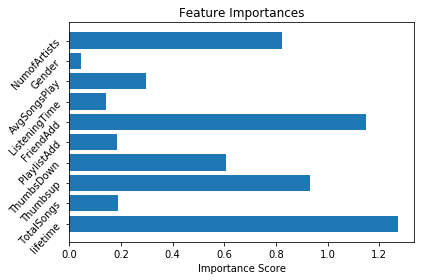

In [414]:
feat_imp = abs(bestModel.coefficients.values)
cols = ["lifetime", "TotalSongs", "Thumbsup", \
          'ThumbsDown','PlaylistAdd','FriendAdd','ListeningTime','AvgSongsPlay', \
        'Gender', 'NumofArtists']
y_pos = np.arange(len(cols))
 
plt.pyplot.barh(y_pos, feat_imp, align='center')
plt.pyplot.yticks(y_pos,cols, rotation = 47)
plt.pyplot.xlabel('Importance Score')
plt.pyplot.title('Feature Importances');
plt.pyplot.tight_layout()
plt.pyplot.show()

## Conclusion

We started with dataclearning in which we first removed the rows where there was not any  UserId and  introduced 10 new feature using feature engineering along with we encoded some with binary variables.

 
In this project 3 model were used  like  Logistic regression, Gradient Boosted Tree and Random Forest. However Logistick Regression and Randomforest result were seen good (similar). Hence we tuned the Logistic Regression model manually and used cross validation and grid search were used. Which resulted in  81% accuracy and 78% F1 score on test set using Logistic Regression.

From the above we clearly see that the lifetime is the greatest important feature along with thumbs down and friends added by the churners. This makes top 3 important features.
We can easily say that the person about to churn did not like the quality of songs either by his/her liking or the audio quality. Such people did not referred friends which was very obvious. Thought the length of using service seems to dominate the behaviour to churn, it could be biased. Because, the churned customers used the product for shorter time. Hence we can consider some other transformations to mitigate this bias.

### Drawbacks/Way forward: 
Hyper tuning the parameter in the model would certainly work towards acquiring a higher F1 score and accuracy; expanding the Grid Search. 
we can use various other high performance models like Xgboost to see how it performs. At the same time we have also seen some more variables could also be engineered based on Domain knowledge

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.